# studentsagainstdiscrimination

In [2]:
import json

with open('StudentsAgainstDiscrimination/result.json') as f:
    my_json = json.load(f)

In [3]:
import pandas as pd
my_keys = set()
emojis = set()
hashtags = set()
for message in my_json['messages']:
    if pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06"):
        my_keys = my_keys.union(set(message.keys()))
        if ('reactions' in message) and (len(message['reactions']) >0):
            for rxn in message['reactions']:
                emojis.add(rxn['emoji'])
        if ('text_entities' in message) and (len(message['text_entities'] )> 0):
            hashtags = hashtags.union(set([i['text'] for i in message['text_entities'] if i['type']=='hashtag']))


In [4]:
import pandas as pd
from collections import defaultdict
import numpy as np

res_dict = defaultdict(list)
emoji_dict = defaultdict(list)
hashtag_dict = defaultdict(list)

for message in my_json['messages']:
    
    if (pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06")) and (pd.to_datetime(message['date']) > pd.to_datetime("2024-01-01")) and (message['type']=='message'):
        for k, v in message.items():
            res_dict[k].append(str(v))
        text_plain = ''.join([i['text'] for i in message['text_entities'] if (i['type']!='hashtag') and (i['type']!='mention')])
        if ('photo' in message) and (pd.notnull(message['photo'])):
            text_plain = "media_image\n" + text_plain
        if ('media_type' in message):
            if message['media_type'] == 'video_file':
                text_plain = "media_video\n" + text_plain
            if message['media_type'] == 'voice_message':
                text_plain = "media_audio\n" + text_plain
        res_dict['text_plain'].append(text_plain)
        un_list = [i for i in my_keys if i not in message]
        for i in un_list:
            res_dict[i].append(np.nan)
        
        temp_emojis = dict()
        emoji_dict['id'].append(message['id'])
        if ('reactions' in message) and (len(message['reactions']) > 0):
            temp_emojis = {i['emoji']:i['count'] for i in message['reactions']}
        
        for k, v in temp_emojis.items():
            emoji_dict[k].append(v)
        un_emojis = [i for i in emojis if i not in temp_emojis]
        for i in un_emojis:
            emoji_dict[i].append(np.nan)
        
        temp_hashs = set()
        hashtag_dict['id'].append(message['id'])
        if ('text_entities' in message) and (len(message['text_entities']) > 0):
            for j in [i['text'] for i in message['text_entities'] if i['type']=='hashtag']:
                if j not in temp_hashs:
                    temp_hashs.add(j)
                    hashtag_dict[j].append(1)
        un_hashs = [i for i in hashtags if i not in temp_hashs]
        for i in un_hashs:
            hashtag_dict[i].append(np.nan)

In [5]:
result_df = pd.DataFrame(res_dict)
result_df = result_df[result_df['text_plain'].apply(len)>0].reset_index(drop=True)
result_df['id'] = result_df['id'].astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])

emoji_df = pd.DataFrame(emoji_dict)
emoji_df['id'] = emoji_df['id'].astype(int)

hashtag_df = pd.DataFrame(hashtag_dict)
hashtag_df['id'] = hashtag_df['id'].astype(int)


result_df['num_reactions'] = result_df['id'].map(emoji_df.set_index('id').sum(axis=1).to_dict())
result_df['weights'] = np.sqrt(result_df['num_reactions']+1).astype(int)

In [6]:
from bnlp import NLTKTokenizer, BengaliCorpus
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from contextlib import redirect_stdout

snowball_stemmer = nltk.stem.SnowballStemmer('english')

stemmer = BanglaStemmer()

# bnltk_tokenizer = NLTKTokenizer()
twt_tokenizer = TweetTokenizer()

ignore_words = stopwords.words('english') + BengaliCorpus.stopwords + list(BengaliCorpus.punctuations) + ['➡', "", "click", "..", "..."]

def process_texts(x):
    x = x.lower().replace("।", "")
    
    nltk_tokens = twt_tokenizer.tokenize(x)
    filtered_nltk_tokens = [i for i in nltk_tokens if (i not in ignore_words) and (len(i.strip())> 1)]
    # filtered_tokens = [i for i in stemmed_tokens if i not in BengaliCorpus.stopwords]
    stemmed_tokens = [snowball_stemmer.stem(i) for i in filtered_nltk_tokens]
    # x = " ".join(stemmed_tokens)
    
    
    # tokens = bnltk_tokenizer.word_tokenize(x)
    
    with open(os.devnull, 'w') as f:
        with redirect_stdout(f):
            stemmed_tokens = [stemmer.stem(i) for i in stemmed_tokens]
    
    return [i for i in stemmed_tokens if len(i) >0]



result_df['documents'] = result_df['text_plain'].apply(process_texts)


result_df['documents']=result_df['documents'].apply(lambda x: [i for i in x if len(i)>1])


punkt not found. downloading...


[nltk_data] Downloading package punkt_tab to /home/fahim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/fahim/miniconda3/envs/llm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel


result_df_subset = result_df[result_df['documents'].apply(len)>0].reset_index(drop=True)

dictionary = Dictionary(result_df_subset['documents'])


weighted_corpus = []
for i, text in enumerate(result_df_subset['documents']):
    bow = dictionary.doc2bow(text)
    weighted_bow = []
    for word_id, count in bow:
        weighted_bow.append((word_id, count * result_df_subset['weights'].iloc[i]))
    weighted_corpus.append(weighted_bow)

lda_model = LdaModel(weighted_corpus, 3, id2word=dictionary)

print(lda_model.log_perplexity(weighted_corpus))

cohere_model = CoherenceModel(model=lda_model, corpus=weighted_corpus, dictionary=dictionary, coherence='u_mass')
print(cohere_model.get_coherence())
lda_model.print_topics()

-7.740063125243452
-2.850749183569841


[(0,
  '0.064*"media_imag" + 0.011*"ছাত্র" + 0.011*"ঢাকা" + 0.011*"আন্দোলন" + 0.010*"সমন্বয়ক" + 0.007*"বিশ্ববিদ্যালয়" + 0.007*"media_video" + 0.007*"শিক্ষার্থী" + 0.007*"সকল" + 0.006*"ছাত্রলীগ"'),
 (1,
  '0.012*"media_video" + 0.012*"শিক্ষার্থী" + 0.012*"ছাত্র" + 0.011*"media_imag" + 0.011*"আন্দোলন" + 0.007*"এক" + 0.007*"করুন" + 0.007*"ঢাকা" + 0.006*"সাথে" + 0.006*"হয়"'),
 (2,
  '0.019*"media_video" + 0.018*"media_imag" + 0.013*"হয়" + 0.009*"পুলিশ" + 0.007*"ছাত্রলীগ" + 0.007*"এক" + 0.006*"আপনা" + 0.006*"সবা" + 0.005*"জুলা" + 0.005*"ছাত্র"')]

(array([19921., 19925., 19929., 19933., 19936., 19940.]),
 [Text(19921.0, 0, '2024-07-17'),
  Text(19925.0, 0, '2024-07-21'),
  Text(19929.0, 0, '2024-07-25'),
  Text(19933.0, 0, '2024-07-29'),
  Text(19936.0, 0, '2024-08-01'),
  Text(19940.0, 0, '2024-08-05')])

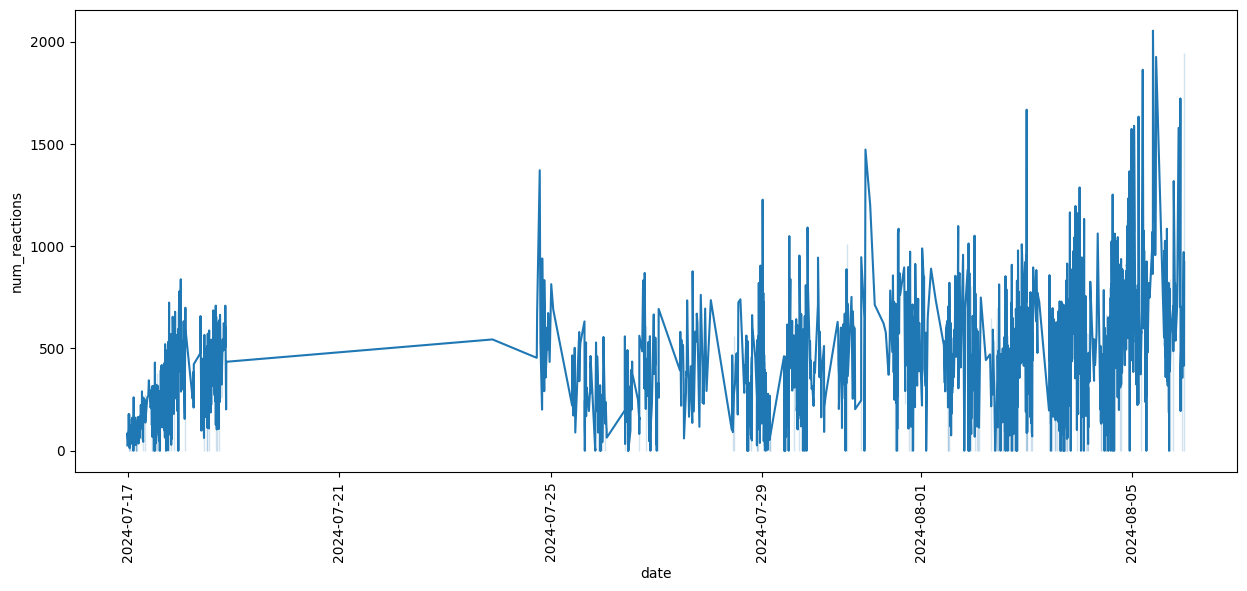

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(x=result_df['date'], y=result_df['num_reactions'] )
plt.xticks(rotation=90,)

In [9]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, weighted_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.008642 -0.069142       1        1  35.850152
2     -0.081104  0.028735       2        1  34.021892
0      0.072462  0.040408       3        1  30.127955, topic_info=            Term          Freq         Total Category  logprob  loglift
39    media_imag  27103.000000  27103.000000  Default  30.0000  30.0000
6774          ৩৩   1238.000000   1238.000000  Default  29.0000  29.0000
786      সমন্বয়ক   4297.000000   4297.000000  Default  28.0000  28.0000
5703       গণভবন   1129.000000   1129.000000  Default  27.0000  27.0000
1843      আহ্বান   1784.000000   1784.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
205           এক    894.042714   5498.641209   Topic3  -5.7419  -0.6168
533         জনতা    725.573700   2049.592396   Topic3  -5.9507   0.1613
1116       মানুষ    767.033006   3093.165976   Topic3  -5.8951  -0.1947
758          দফা    714.434527   1868.195607   Topic3  -5.9661   0.2385
1081      আওয়ামী    727.346629   2477.876456   Topic3  -5.9482  -0.0260

[311 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1153      1  0.983074       back
5742      3  0.984743      clear
3999      1  0.014225  democraci
3999      2  0.981512  democraci
7445      3  0.978408        der
...     ...       ...        ...
6774      1  0.000808         ৩৩
6774      2  0.998361         ৩৩
6774      3  0.000808         ৩৩
5009      1  0.001662        ️‍🔥
5009      2  0.998927        ️‍🔥

[584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [10]:
result_df_subset['text_plain'].str.contains('media_').sum()

2549

In [11]:
len(result_df_subset)

3370

In [12]:
result_df_subset['from'].value_counts()

from
বৈষম্যবিরোধী ছাত্র আন্দোলন    3370
Name: count, dtype: int64